# Unsupervised learning 
## Creating customer segments

you will analyze a dataset containing data on various customers' annual spending amounts (reported in monetary units) of diverse product categories for internal structure. One goal of this project is to best describe the variation in the different types of customers that a wholesale distributor interacts with. Doing so would equip the distributor with insight into how to best structure their delivery service to meet the needs of each customer.
The dataset for this project can be found on the UCI Machine Learning Repository. For the purposes of this project, the features 'Channel' and 'Region' will be excluded in the analysis — with focus instead on the six product categories recorded for customers.

In [229]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from IPython.display import display 
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [48]:
customers = pd.read_csv('customers.csv')
customers.drop(['Region', 'Channel'], axis = 1, inplace = True)

In [50]:
customers.shape

(440, 6)

In [3]:
customers.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


## Data Exploration


In [4]:
pd.options.display.float_format = '{:,.2f}'.format
customers.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.00,440.00,440.00,440.00,440.00,440.00
mean,"12,000.30","5,796.27","7,951.28","3,071.93","2,881.49","1,524.87"
std,"12,647.33","7,380.38","9,503.16","4,854.67","4,767.85","2,820.11"
min,3.00,55.00,3.00,25.00,3.00,3.00
25%,"3,127.75","1,533.00","2,153.00",742.25,256.75,408.25
50%,"8,504.00","3,627.00","4,755.50","1,526.00",816.50,965.50
75%,"16,933.75","7,190.25","10,655.75","3,554.25","3,922.00","1,820.25"
max,"112,151.00","73,498.00","92,780.00","60,869.00","40,827.00","47,943.00"


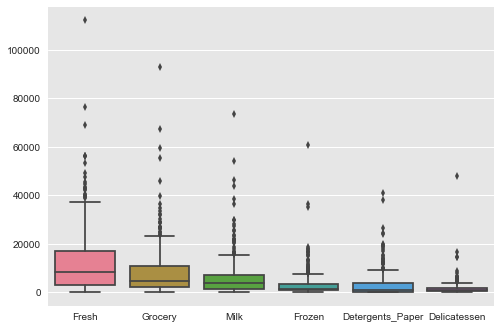

In [10]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_palette(sns.color_palette("husl", 6))
sns.boxplot(data=customers, order=customers.mean(axis=0).nlargest(6).index);

Each of all six features has the mean much larger than its median, indicating the ditributions are **skewed to the right**. A general rule of thumb to determine the skewness of each feature is to check the ratio of the maximum value to lowest value. If the ratio is greater than 20, it is considered as a skewed data. All six features in our data set have the max / min value ratios well above 20, suggesting extremely right skeweness of the data. Transformation of data seems to be required to remove the skewess if we are to implement learning algorithms that are sensitive to feature scales.

### Feature relevance
One interesting thought to consider is if one (or more) of the six product categories is actually relevant for understanding customer purchasing. That is to say, is it possible to determine whether customers purchasing some amount of one category of products will necessarily purchase some proportional amount of another category of products? We can make this determination quite easily by training a supervised regression learner on a subset of the data with one feature removed, and then score how well that model can predict the removed feature.

#### Question:
Which feature did you attempt to predict? What was the reported prediction score? Is this feature is necessary for identifying customers' spending habits?

In [227]:
new_data = customers.copy()
new_data = new_data.drop(['Grocery'], axis = 1)
y = customers['Grocery']

# Split the data into training and testing sets using the given feature as the target
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(new_data, y, test_size = .25, random_state = 247)

# Create a decision tree regressor and fit it to the training set
from sklearn import tree
regressor = tree.DecisionTreeRegressor(max_depth = 5, random_state = 247)
regressor.fit(X_train, y_train)

# Report the score of the prediction using the testing set
from sklearn.metrics import r2_score

predicted = regressor.predict(X_test)
score = r2_score(y_test, predicted)
print("Model has a coefficient of determination, R^2, of {:.3f}.".format(score))

Model has a coefficient of determination, R^2, of 0.793.



I chose the 'Grocery' as target label of the regression tree model because the cumulative distribution of each sample showed that the percentiles for grocery and milk are very nearly close (especially for sample 0 and sample 1). The R^2 metric of 0.793 implies that about 80% of the variation of grocery purchase can be explained by other features. However I wouldn't exclude this variable yet until other statistics strongly suggest so, because a) the R^2 score tends to increase as more features are added to the multivariate regression model. This decent score could just come from the fact that we are considering many features. b) As we've seen in sample 1's case, there could be many cases that grocery spending not perfectly identifie their spending characteristics. c) It should also be mentioned that the hyperparameter chosen(max_depth) for the learning algorithm are not optimally calibarated, and the performance metric is subject to change with varying maximum depth of the tree. d) If there is indeed a hidden pattern in the data, the principal components analysis and cluster analysis will discover it. Let's continue.

## Data Preprocessing
## log transformation

In [327]:
transformed = customers.apply(func=np.log, axis=1)

In [328]:
transformed.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,9.45,9.18,8.93,5.37,7.89,7.20
1,8.86,9.19,9.17,7.47,8.10,7.48
2,8.76,9.08,8.95,7.79,8.17,8.97
3,9.49,7.09,8.35,8.76,6.23,7.49
4,10.03,8.60,8.88,8.27,7.48,8.55


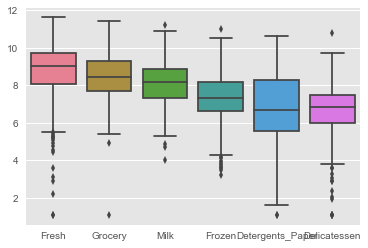

In [329]:
sns.boxplot(data=transformed, order=customers.mean(axis=0).nlargest(6).index);

In [120]:
#sns.pairplot(transformed, kind='reg');

After applying logarithmic scaling, the distribution of each feature looks more centered and evenly distributed around its uni-mode (except Detergent_paper which seems to have two modes). They are not entirely symmetric but these data points much better behave than before transformation. The strong correlations (Milk vs Grocery and Grocery vs Detergent_paper) identified in the raw data look even more evident now. Moreover, the relation between Milk and Detergent_paper looks more linear after transformation. It suggests Milk, Grocery, and Detergent_paper might have a latent structure in the data.

# Outlier detection

Detecting outliers in the data is extremely important in the data preprocessing step of any analysis. The presence of outliers can often skew results which take into consideration these data points. There are many "rules of thumb" for what constitutes an outlier in a dataset. Here, we will use Tukey's Method for identfying outliers: An outlier step is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.
In the code block below, you will need to implement the following:
- Assign the value of the 25th percentile for the given feature to Q1. Use np.percentile for this.
- Assign the value of the 75th percentile for the given feature to Q3. Again, use np.percentile.
- Assign the calculation of an outlier step for the given feature to step.
- Optionally remove data points from the dataset by adding indices to the outliers list.
NOTE: If you choose to remove any outliers, ensure that the sample data does not contain any of these points!
Once you have performed this implementation, the dataset will be stored in the variable good_data.

In [11]:
desc = transformed.describe()
iqr = desc.loc['75%', :] - desc.loc['25%', :]
iqr_left = pd.DataFrame(desc.loc['25%', :] - 1.5 * iqr).transpose()
iqr_right = pd.DataFrame(desc.loc['75%', :] + 1.5 * iqr).transpose()
outlier_boundary = pd.concat([iqr_left, iqr_right])
outlier_boundary.index = ['iqr_left', 'iqr_right']

In [12]:
outlier_boundary

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
iqr_left,5.51,5.02,5.28,4.26,1.46,3.77
iqr_right,12.27,11.20,11.67,10.53,12.36,9.75


In [13]:
transformed.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,9.45,9.18,8.93,5.37,7.89,7.20
1,8.86,9.19,9.17,7.47,8.10,7.48
2,8.76,9.08,8.95,7.79,8.17,8.97
3,9.49,7.09,8.35,8.76,6.23,7.49
4,10.03,8.60,8.88,8.27,7.48,8.55


In [14]:
outliers_by_features = {}
outliers = []
for feature in transformed.columns:
    possible_outliers = transformed.loc[
        ~((transformed[feature] > outlier_boundary.loc['iqr_left', feature]) &
          (transformed[feature] < outlier_boundary.loc['iqr_right', feature]))]
    outliers_by_features[feature] = list(possible_outliers.index)
    outliers.append(list(possible_outliers.index))
outliers = np.unique(sum(outliers, []))

In [51]:
len(outliers)

42

In [16]:
good_data = transformed.drop(transformed.index[outliers]).reset_index(drop = True)

## Feature decomposition - PCA
In this section you will use **principal component analysis (PCA)** to draw conclusions about the **underlying structure** of the wholesale customer data. Since using PCA on a dataset calculates the **dimensions which best maximize variance**, we will find which compound combinations of features best describe customers.



Now that the data has been scaled to a more normal distribution and has had any necessary outliers removed, we can now apply PCA to the good_data to discover which dimensions about the data best maximize the variance of features involved. In addition to finding these dimensions, PCA will also report the **explained variance ratio of each dimension — how much variance within the data is explained by that dimension alone.** Note that a component (dimension) from PCA can be considered a new "feature" of the space, however it is a composition of the original features present in the data.


In [238]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 6, whiten = True, random_state = 247)
pca.fit(good_data)
explained_2 = sum(pca.explained_variance_ratio_[:2]) * 100
explained_4 = sum(pca.explained_variance_ratio_[:4]) * 100
print("Total variance explained by first two pricipal components: {:.2f} %".format(explained_2))
print("Total variance explained by first four pricipal components: {:.2f} %".format(explained_4))

Total variance explained by first two pricipal components: 72.53 %
Total variance explained by first four pricipal components: 92.80 %


In [239]:
sns.set_palette(sns.color_palette("husl", 6))
def pca_results(good_data, pca):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''

    # Dimension indexing
    dimensions = ['Dimension {}'.format(i) \
                               for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = good_data.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (14,8))

    # Plot the feature weights as a function of the components   
    components.plot(ax = ax, kind = 'bar', linewidth=1);
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)


    # Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n %.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

,Explained Variance,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Dimension 1,0.50,-0.10,0.41,0.45,-0.13,0.76,0.16
Dimension 2,0.23,0.60,0.14,0.09,0.63,-0.04,0.46
Dimension 3,0.10,-0.75,0.15,-0.02,0.27,-0.23,0.54
Dimension 4,0.10,0.27,0.14,0.07,-0.71,-0.32,0.54
Dimension 5,0.05,0.01,0.71,0.32,0.07,-0.47,-0.41
Dimension 6,0.02,-0.05,-0.52,0.83,0.05,-0.21,-0.01


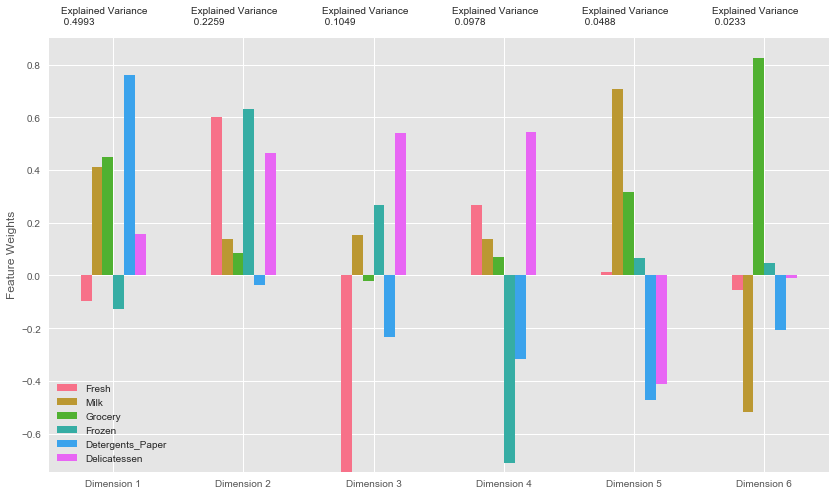

In [240]:
results = pca_results(good_data, pca)
display(results)

About 70% of variance is explained by the first two principal components. First four principal components explain about 93% of variance in the data.

- The dimension 1 summarizes the most variability of the data. The signs of feature weights were the same for the Grocery, Milk and Detergent_Paper. The magnitude of detergent_paper was the largest, closely followed by grocery and milk. The high correlation between the Grocery and Milk, and Detergent_Paper, seemed to lead them to pretty similar directions in the first principal component. Roughly speaking, on the dimension 1, the data points were separated into two groups: low annaul spending on grocery, milk, and detergent_paper versus high spending on grocery, milk, and detergent_paper.
- On dimension 2, the second proncipal component distinguishes customers who have large order on frozen food, fresh, and delicatessen from the customers who don't. The Frozen and Delicatessen have very nearly the same sign and magnitude of feature weights, and Fresh was larger than them. This suggests strong correlation between Frozen and Fresh, which was not revealed in the data exploration step.
- Dimension 3 separates the customers with small order of fresh and large order of delicatessen from customers with large order of fresh and small order of delicatessen.
- The Dimension 4 further splits the space of data points depending on the amount of spending on delicatessen and frozen orders, moving customers who spend much on delicatessen to the negative direction, and on frozen to the positive direction.

### Dimensionality reduction 

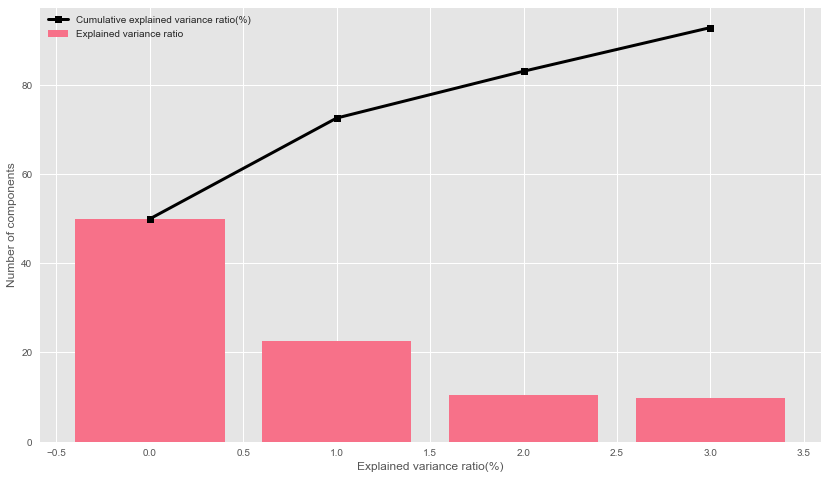

In [324]:
fig, ax = plt.subplots(figsize = (14,8))
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_ * 100, linewidth=2,
       label='Explained variance ratio')
plt.plot(features, np.cumsum(pca.explained_variance_ratio_ * 100), linewidth=3,
    marker='s', label='Cumulative explained variance ratio(%)', color='#000000')
plt.xlabel('Explained variance ratio(%)')
plt.ylabel('Number of components')
plt.legend(loc='best')
plt.show()

The plot above shows that about 70% of variance is explained by the first and second principal components. First four principal components explain about 92% of variance in the data. Arguably 2 or 4 principal components could be our break (Including all feature won't help dimensionality reduction).

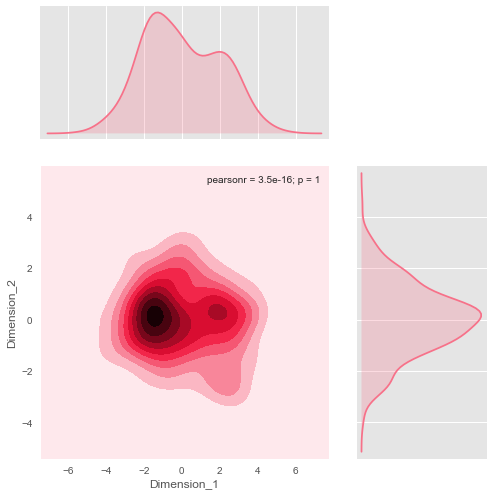

In [323]:
pca = PCA(n_components = 4)
pca.fit(good_data)

# TODO: Transform the good data using the PCA fit above
reduced_data = pca.transform(good_data)


# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, 
                            columns = ['Dimension_1', 'Dimension_2', 'Dimension_3', 'Dimension_4'])

# Produce a scatter matrix for pca reduced data
sns.jointplot(reduced_data.iloc[:, 0], reduced_data.iloc[:, 1],\
            size = 7, ratio = 2, kind = "kde");

The kernel density estimate on two principal components are plotted above. It is clear that the samples are splitted into two segments on the dimension 1. This is reinforced by two modes (around -2.5 and 2.5) in the distribution on the diemnsion 1. On the positive plane of dimension 1, the segment is further splitted into two sub-segments. However the variation is not as strong as the first principal component. It can be merely observed on the right tail of the distribution on dimension 2. Transformed PAC features have very small number of Pearson r, meaning the dataset is 'de-correlated' 

In [243]:
mycol = sns.color_palette("husl", 6)
def biplot(good_data, reduced_data, pca):
    '''
    Produce a biplot that shows a scatterplot of the reduced
    data and the projections of the original features.
    
    good_data: original data, before transformation.
               Needs to be a pandas dataframe with valid column names
    reduced_data: the reduced data (the first two dimensions are plotted)
    pca: pca object that contains the components_ attribute

    return: a matplotlib AxesSubplot object (for any additional customization)
    
    This procedure is inspired by the script:
    https://github.com/teddyroland/python-biplot
    '''

    fig, ax = plt.subplots(figsize = (14,8))
    # scatterplot of the reduced data    
    ax.scatter(x=reduced_data.loc[:, 'Dimension_1'], y=reduced_data.loc[:, 'Dimension_2'], 
        facecolors= mycol[3], s=100, alpha=0.8)
    
    feature_vectors = pca.components_.T

    # we use scaling factors to make the arrows easier to see
    arrow_size, text_pos = 7.0, 8.0,

    # projections of the original features
    for i, v in enumerate(feature_vectors):
        ax.arrow(0, 0, arrow_size*v[0], arrow_size*v[1], 
                  head_width=0.2, head_length=0.2, linewidth=2, color=mycol[0])
        ax.text(v[0]*text_pos, v[1]*text_pos, good_data.columns[i], color="#000000", 
                 ha='center', va='center', fontsize=12)

    ax.set_xlabel("Dimension 1", fontsize=14)
    ax.set_ylabel("Dimension 2", fontsize=14)
    #ax.set_title("PC plane with original feature projections.", fontsize=16);
    return ax

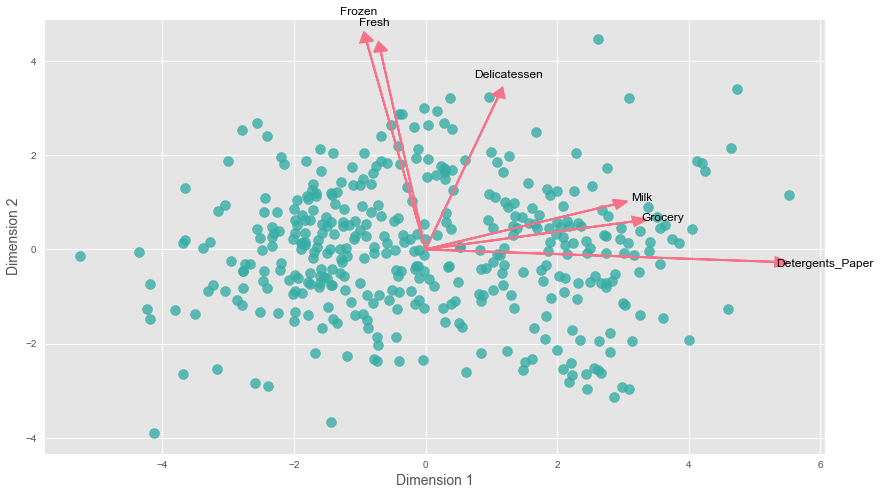

In [245]:
biplot(good_data, reduced_data, pca);

The Detergent_Paper is very nearly the same as the fist component in negative direction. Grocery and Milk, which are strongly correlated with the Detergent_Paper, are strongly projected on the first component. Fresh highly correlates with Frozen, and these two very strongly projects on to the negative direction of dimension 2. Delicatessan is weakly correlates with Frozen and Fresh. This observation is consistent with the pca_results plot obtained above. While biplot depicts only first two dimensions, it is more easily interpretable with feature axes and data points.

# Clustering - K-means

#### Question
What are the advantages to using a **K-Means** clustering algorithm? What are the advantages to using a **Gaussian Mixture Model** clustering algorithm? Given your observations about the wholesale customer data so far, which of the two algorithms will you use and why?

#### Answer:
Both K-Means clustering algorithm and Gaussian Mixure model are iterative algotithms to assign data points to clusters. K-means clustering algorithm is not only easy to implement (even with really large datasets), also computationally very efficient compared to other clustering algorithms. As it is a type of **hard clustering**, it assigns cluster deterministically, not probabilitically. Gaussian Mixture Model, a **soft clusterin**g, however, returns probabilities for each data point of belonging to each cluster.
For the following clustering analysis, we will use a K-mean algorithm, because as it is shown in the kernel density estimate plot for the reduced_data, the possible clusters have sphere-shaped. Another drawback of K-Means is that we have to specify the number of clusters a priori. For this analysis, we'll use K-mean clustering technique and quality the clutering output using the elbow method and silhouette plots to identify the optimal number of clusters.


#### Implementation: Creating Clusters
Depending on the problem, the number of clusters that you expect to be in the data may already be known. When the number of clusters is not known a priori, there is no guarantee that a given number of clusters best segments the data, since it is unclear what structure exists in the data — if any. However, we can quantify the "goodness" of a clustering by calculating each data point's silhouette coefficient. The silhouette coefficient for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). Calculating the mean silhouette coefficient provides for a simple scoring method of a given clustering.

In [319]:
from sklearn.cluster import KMeans
n_clusters = range(2, 7)
scores = []
distortions = []
for i in n_clusters:
    clusterer = KMeans(n_clusters = i, random_state = 247).fit(reduced_data)
    labels = clusterer.labels_
    distortions.append(clusterer.inertia_)
    score = silhouette_score(reduced_data, labels, metric='euclidean')
    scores.append(score)
    print("For n_cluster" , n_clusters[i-2], ",", "the silhouette score is: ",\
    round(score, 4))

For n_cluster 2 , the silhouette score is:  0.3472
For n_cluster 3 , the silhouette score is:  0.2516
For n_cluster 4 , the silhouette score is:  0.2126
For n_cluster 5 , the silhouette score is:  0.2221
For n_cluster 6 , the silhouette score is:  0.2338


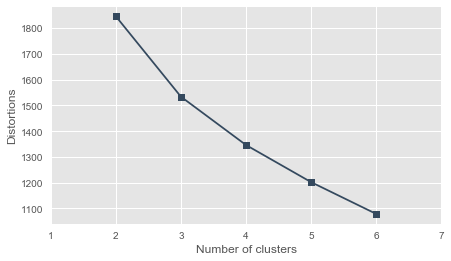

In [331]:
fig, ax = plt.subplots(figsize = (7,4))
plt.plot(range(2, 7), distortions, marker = "s", color="#34495e")
axes = plt.gca()
#axes.set_ylim([600, 2000])
plt.xlabel("Number of clusters")
plt.ylabel("Distortions")
plt.xticks([1, 2, 3, 4, 5, 6, 7]);

The distortion decreases as the number of clusters increases. The rate of decrease of distortion slows down at the third clusters. Arguably, two or three clusters can be a good number.

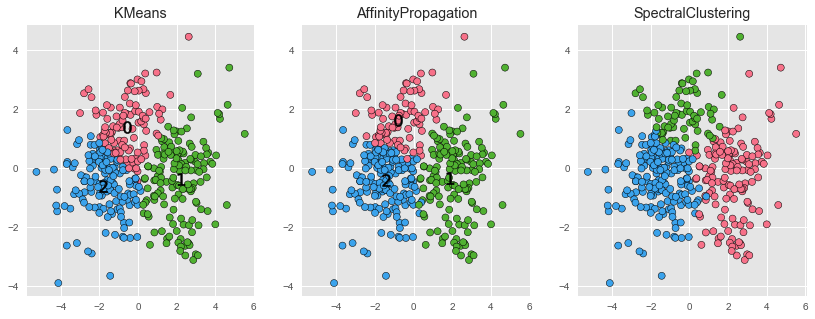

In [301]:
import time
from sklearn import cluster
from matplotlib.colors import ListedColormap

colors = ListedColormap(sns.color_palette("husl", 3).as_hex())
clustering_names = ['KMeans', 'AffinityPropagation', 'SpectralClustering']
km = cluster.KMeans(n_clusters=3)
affinity = cluster.AffinityPropagation(damping=0.9, preference=-200)
spectral = cluster.SpectralClustering(
    n_clusters=3, eigen_solver='arpack', affinity="nearest_neighbors")
dbscan = cluster.DBSCAN(eps=2)
clustering_algorithms = [km, affinity, spectral]

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True, figsize=(14, 5))
my_ax = [ax1, ax2, ax3]
for i, (name, algorithm) in enumerate(zip(clustering_names, cluster_algorithms)):
    algorithm.fit(reduced_data)
    y_pred = pd.Series(algorithm.labels_.astype(np.int), name='label')
    tmp = pd.concat([reduced_data, y_pred], axis=1)
    
    plt.subplot(1, 3, i+1)
    plt.scatter(tmp.iloc[:, 0], tmp.iloc[:, 1], c=tmp.loc[:, 'label'], cmap=colors,
               edgecolors='black')
    if hasattr(algorithm, 'cluster_centers_'):
        centers = algorithm.cluster_centers_
        for c in range(len(centers)):
            plt.scatter(centers[c, 0], centers[c, 1], marker='$%d$'%(c), alpha = 1, 
                        color='black', s=150)
    plt.title(clustering_names[i])
   

### Data recovery
Each cluster present in the visualization above has a central point. These centers (or means) are not specifically data points from the data, but rather the averages of all the data points predicted in the respective clusters. For the problem of creating customer segments, a cluster's center point corresponds to the average customer of that segment. Since the data is currently reduced in dimension and scaled by a logarithm, we can recover the representative customer spending from these data points by applying the inverse transformations.

In [288]:
# TODO: Inverse transform the centers
log_centers = pca.inverse_transform(centers)

# TODO: Exponentiate the centers
true_centers = np.exp(log_centers)

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = customers.keys())
true_centers.index = segments
print("Representative customers spending ($):")
display(true_centers)


Representative customers spending ($):


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,"21,288.00","3,212.00","3,692.00","4,328.00",401.00,"2,112.00"
Segment 1,"6,838.00","6,513.00","10,167.00",954.00,"3,848.00",878.00
Segment 2,"6,204.00","1,843.00","2,314.00","1,520.00",286.00,683.00


## Conclusion

#### Question 
Additional structure is derived from originally unlabeled data when using clustering techniques. Since each customer has a customer segment it best identifies with (depending on the clustering algorithm applied), we can consider 'customer segment' as an engineered feature for the data. Assume the wholesale distributor recently acquired ten new customers and each provided estimates for anticipated annual spending of each product category. Knowing these estimates, the wholesale distributor wants to classify each new customer to a customer segment to determine the most appropriate delivery service.
How can the wholesale distributor label the new customers using only their estimated product spending and the customer segment data?
Hint: A supervised learner could be used to train on the original customers. What would be the target variable?
#### Answer:
We can utilize the resulted engineered feature as our new target label. The problem of assigning ten new customers to each segment boils down to a supervised learning problem, specifically a classification problem. One comprehensible example would be K-nearest-neighbors. For each new customer, find k most similar samples in the data set and assign the customer segent label by majority rule. By applying these engineered feature and the results from A/B testing in question 10, the company could set the targeted and tailored delivery schedule for these new customers.

In [338]:
def channel_results(reduced_data, outliers, km):
	'''
	Visualizes the PCA-reduced cluster data in two dimensions using the full dataset
	Data is labeled by "Channel" and cues added for student-selected sample data
	'''
	full_data = pd.read_csv("customers.csv")
	channel = pd.DataFrame(full_data['Channel'], columns = ['Channel'])
	channel = channel.drop(channel.index[outliers]).reset_index(drop = True)
	labeled = pd.concat([reduced_data, channel], axis = 1)
	
	# Generate the cluster plot
	fig, ax = plt.subplots(figsize = (11,7))

	# Color map
	colors = ListedColormap(sns.color_palette("husl", 3).as_hex())

	# Color the points based on assigned Channel
	labels = ['Hotel/Restaurant/Cafe', 'Retailer']
	grouped = labeled.groupby('Channel')
	plt.scatter(labeled.loc[:, 'Dimension_1'], labeled.loc[:, 'Dimension_2'],
           c = labeled.loc[:, 'Channel'], cmap=colors, edgecolors='black')
	km.fit(reduced_data)
	centers = km.cluster_centers_

	for c in range(len(centers)):
            plt.scatter(centers[c, 0], centers[c, 1], marker='$%d$'%(c), alpha = 1, 
                        color='black', s=200)
	# Set plot title
	
	ax.set_title("PCA-Reduced Data Labeled by 'Channel'\nTransformed Sample Data Circled");

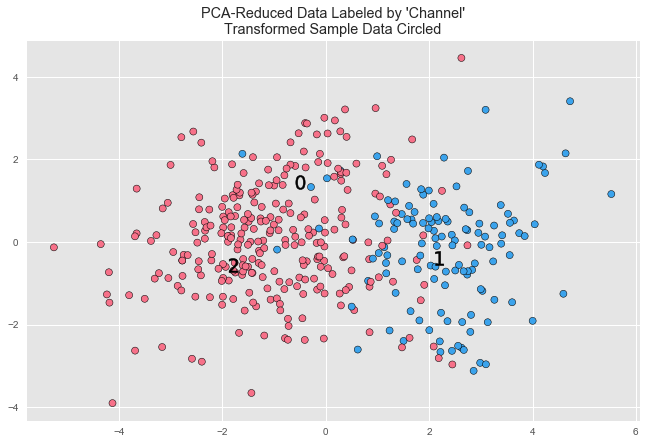

In [339]:
channel_results(reduced_data, outliers, km)

Surprisingly, the first component fairly well splits the data according to the the channel feature. Almost all of data points identified as Segment 1 actually fall into the retailers. Also, data points on the range [-5, -0] on the dimension 1 were clustered as segment 2, and identified as Hotel/Restausrants/Cafe. However, the range [0, 2] on the dimension has a mix of data points from both channels, and captured as segment 0. 